In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# We can view all of the classes that automap found
# classes are tables
for c in Base.classes:
    print(c)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [24]:
q = sqlalchemy.text("SELECT measurement.station, measurement.date FROM measurement")
result = session.execute(q)

for row in result:
    print(row)
    break

('USC00519397', '2010-01-01')


In [21]:
result = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs)
df = pd.DataFrame(result)
df

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65.0
1,USC00519397,2010-01-02,0.00,63.0
2,USC00519397,2010-01-03,0.00,74.0
3,USC00519397,2010-01-04,0.00,76.0
4,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...
19545,USC00516128,2017-08-19,0.09,71.0
19546,USC00516128,2017-08-20,NaN,78.0
19547,USC00516128,2017-08-21,0.56,76.0
19548,USC00516128,2017-08-22,0.50,76.0


In [60]:
r = session.query(func.max(Measurement.date))
date = r[0]
date = pd.to_datetime(date)[0]
start_date = date - pd.DateOffset(months=12)
for i, c in enumerate(str(start_date)):
    print(i,c)

0 2
1 0
2 1
3 6
4 -
5 0
6 8
7 -
8 2
9 3
10  
11 0
12 0
13 :
14 0
15 0
16 :
17 0
18 0


# Exploratory Climate Analysis

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text major ticklabel objects>)

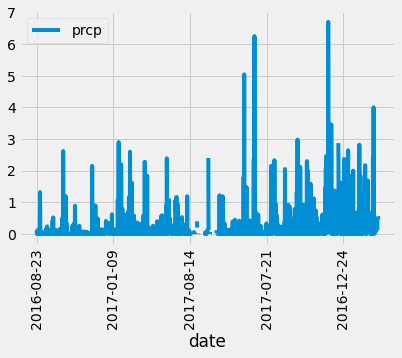

In [62]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
r = session.query(func.max(Measurement.date))
date = r[0]
date = pd.to_datetime(date)[0]
start_date = date - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
r = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date >= str(start_date)[:10])

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(r)

# Sort the dataframe by date
df.sort_values(by="date")
# Use Pandas Plotting with Matplotlib to plot the data

df.plot("date", "prcp")
plt.xticks(rotation=90)

In [64]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()["prcp"]

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [65]:
# Design a query to show how many stations are available in this dataset?
r = session.query(func.count(Station.station))

r[0]

(9)

In [67]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
q = sqlalchemy.text("""
SELECT station, count(date) AS freq FROM measurement
GROUP BY station
ORDER BY freq DESC""")

r = session.execute(q)
pd.DataFrame(r)

,0,1
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [84]:
r = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc())
df = pd.DataFrame(r, columns=("station","count"))
most_active_station = df.loc[0, "station"]
most_active_station, df

('USC00519281',
        station  count
 0  USC00519281   2772
 1  USC00519397   2724
 2  USC00513117   2709
 3  USC00519523   2669
 4  USC00516128   2612
 5  USC00514830   2202
 6  USC00511918   1979
 7  USC00517948   1372
 8  USC00518838    511)

In [76]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
r = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station==most_active_station)
print(r)
r[0]


SELECT min(measurement.tobs) AS min_1, max(measurement.tobs) AS max_1, avg(measurement.tobs) AS avg_1 
FROM measurement 
WHERE measurement.station = ?


(54.0, 85.0, 71.66378066378067)

In [86]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
r = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==most_active_station).filter(Measurement.date >= str(start_date)[:10])
print(r)
pd.DataFrame(r)

SELECT measurement.date AS measurement_date, measurement.tobs AS measurement_tobs 
FROM measurement 
WHERE measurement.station = ? AND measurement.date >= ?


,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
